In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls

gdrive	sample_data


In [3]:
!ls gdrive

MyDrive


In [4]:
import os 
os.chdir("/content/gdrive/My Drive/imza_tanima")
!pwd

/content/gdrive/My Drive/imza_tanima


In [5]:
!ls

Egitim.ipynb  models  sign_samples


##Kütüphaneler ve pathler

In [6]:
import cv2
import numpy as np
import pandas as pd
from scipy import ndimage
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from tqdm import tqdm
import h5py
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop,Adadelta
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate,Dropout
from keras.models import Model
from keras.models import load_model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D , AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense

from keras import backend as K

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn
from scipy.optimize import brentq
from scipy.interpolate import interp1d


import math
from keras.callbacks import LearningRateScheduler

In [7]:
icdar_path ="/content/gdrive/My Drive/imza_tanima/sign_samples/sign_data"
icdar_dir = icdar_path + "/train"
i_train = icdar_path + "/train_pairs.csv"
i_test = icdar_path + "/test_pairs.csv"

##Gerekli fonksiyonlar

In [8]:
def remove_background(img):
  img = img.astype(np.uint8)
  threshold, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  img[img > threshold] = 255

  return img

def pre_proces(path):
    img = cv2.imread(path,0)
    img=remove_background(img)
    img = img/255
    img = cv2.resize(img, (224, 224))
    img = img.reshape((224, 224, 1))
    img = img.astype(np.float32)  
    return img

def get_image_data(data_csv,data_dir):
  x_left = [ ]
  x_right = [ ]
  y = [ ]
  
  data = pd.read_csv(data_csv)
  sample=int(data.shape[0])

  for i in tqdm(range(sample)):
    img0_path=os.path.join(data_dir,data.iat[i,0])
    img1_path=os.path.join(data_dir,data.iat[i,1])

    img0=pre_proces(img0_path)
    img1=pre_proces(img1_path)
    
    img0 = img_to_array(img0)
    img1 = img_to_array(img1)

    x_left.append(img0)
    x_right.append(img1)
    y.append(data.iat[i,2])

  x_left = np.array(x_left).astype('float16') 
  x_right = np.array(x_right).astype('float16') 
  y = np.array(y).reshape((-1,1)).astype('float16') 

  return x_left,x_right,y

In [9]:
def euclidean_distance(vects):
  x, y= vects
  return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

In [10]:
def contrastive_loss(y_true, y_pred):
    # y_pred --> Dw
    margin = 2
    loss_contrastive = K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))
    return loss_contrastive

In [11]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

In [12]:
def draw_plt(history):
  fig, (cx1, cx2) = plt.subplots(2, figsize=(8, 6))

  cx1.plot(history.history['loss'])
  cx1.plot(history.history['val_loss'])

  cx2.plot(history.history['accuracy'])
  cx2.plot(history.history['val_accuracy'])
      
  cx1.set_ylabel('loss')
  cx1.legend(['train', 'test'], loc='upper left')

  cx2.set_ylabel('accuracy')
  cx2.set_xlabel('epoch')
  cx1.legend(['Training', 'Validation'], loc='upper left')
    

In [13]:
def draw_cm(y, y_pred):
  cm =confusion_matrix(y, y_pred)
  sn.heatmap(cm,annot=True,fmt='g',lw=2)
  plt.ylabel("True Values")
  plt.xlabel("PredictedValues")
  plt.title("Confusion Matrix")
  plt.show()

In [14]:
def draw_roc(y, y_pred):
  fpr, tpr, threshold= metrics.roc_curve(y, y_pred)
  roc_auc=metrics.auc(fpr,tpr)

  plt.title('Roc')
  plt.plot(fpr,tpr,'b',label='Auc=%0.2f'%roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [15]:
def fix_it(y_pred):
  for i in range(y_pred.shape[0]):
    if y_pred[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

  return y_pred

In [16]:
def lr_step_decay(epoch, lr):
    initial_learning_rate = 0.001
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

## Model

In [17]:
def siamese_model(input_shape):

    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(64, (7,7), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (5,5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))


    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='sigmoid'))
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([encoded_l,encoded_r])

    siamese_net = Model(inputs=[left_input,right_input],outputs=distance)

    return siamese_net

## Dataset yükleme

In [18]:
train_left, train_right, target = get_image_data(i_train, icdar_dir)

100%|██████████| 5865/5865 [01:16<00:00, 76.17it/s]


In [19]:
test_left, test_right, test_target = get_image_data(i_test, icdar_dir)

100%|██████████| 2685/2685 [00:34<00:00, 77.06it/s]


#Optimizer Tespiti

In [17]:
constant_learning_rate = 0.01

##Adam optimizer ile eğitim

In [30]:
opt=Adam(lr=constant_learning_rate)

model = siamese_model((224,224, 1))
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32)           318720      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential_2[0][0]         

In [31]:
history = model.fit(
    [train_left, train_right],
    target,
    epochs=50,
    validation_split=0.2,
    batch_size=112,
)

Epoch 1/50
42/42 [==============================] - 32s 740ms/step - loss: 1.0442 - accuracy: 0.5258 - val_loss: 1.8615 - val_accuracy: 0.5130
Epoch 2/50
42/42 [==============================] - 30s 723ms/step - loss: 0.8231 - accuracy: 0.5272 - val_loss: 1.8496 - val_accuracy: 0.5227
Epoch 3/50
42/42 [==============================] - 30s 717ms/step - loss: 0.7824 - accuracy: 0.5675 - val_loss: 1.3239 - val_accuracy: 0.6786
Epoch 4/50
42/42 [==============================] - 30s 723ms/step - loss: 0.6823 - accuracy: 0.6021 - val_loss: 0.8258 - val_accuracy: 0.6551
Epoch 5/50
42/42 [==============================] - 30s 719ms/step - loss: 0.5895 - accuracy: 0.6519 - val_loss: 0.7739 - val_accuracy: 0.6990
Epoch 6/50
42/42 [==============================] - 30s 721ms/step - loss: 0.5614 - accuracy: 0.6910 - val_loss: 0.9014 - val_accuracy: 0.6693
Epoch 7/50
42/42 [==============================] - 30s 720ms/step - loss: 0.3793 - accuracy: 0.7797 - val_loss: 1.9727 - val_accuracy: 0.5325

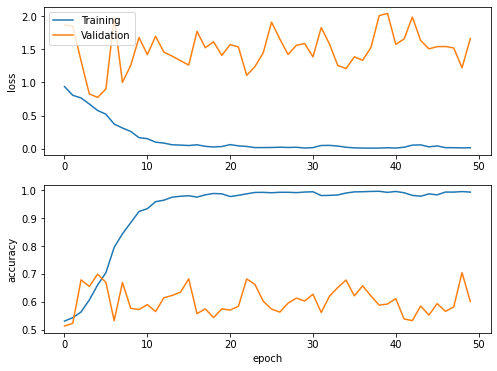

In [32]:
draw_plt(history)

In [33]:
score = model.evaluate([test_left, test_right], test_target, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.5263761281967163 / Test accuracy: 0.6145833134651184


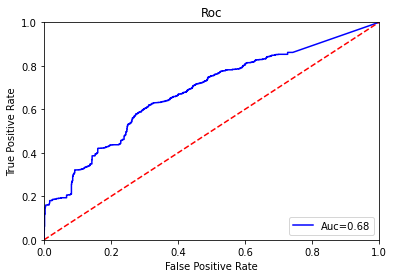

In [34]:
y_pred = model.predict([test_left, test_right])
draw_roc(test_target,y_pred)

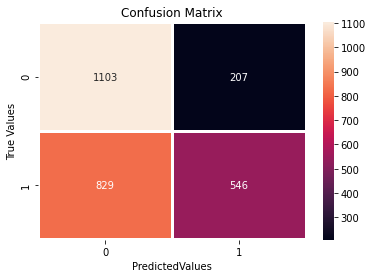

In [35]:
y_pred = fix_it(y_pred)
draw_cm(test_target,y_pred)

In [36]:
f1_score(test_target,y_pred)

0.5131578947368421

In [37]:
fpr, tpr, thresholds =  metrics.roc_curve(test_target, y_pred)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer*100

41.726878543311265

In [38]:
model.save_weights("models/opt_adam.h5")

##RMSprop optimizer ile eğitim

In [44]:
opt=RMSprop(lr=constant_learning_rate)

model = siamese_model((224,224,1))
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           318720      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[0][0]         

In [45]:
history = model.fit(
    [train_left, train_right],
    target,
    epochs=50,
    validation_split=0.2,
    batch_size=112,
)

Epoch 1/50
42/42 [==============================] - 33s 731ms/step - loss: 1.0356 - accuracy: 0.5244 - val_loss: 2.0172 - val_accuracy: 0.5130
Epoch 2/50
42/42 [==============================] - 31s 730ms/step - loss: 0.9023 - accuracy: 0.5380 - val_loss: 1.6723 - val_accuracy: 0.5235
Epoch 3/50
42/42 [==============================] - 30s 715ms/step - loss: 0.8701 - accuracy: 0.5486 - val_loss: 1.7063 - val_accuracy: 0.5300
Epoch 4/50
42/42 [==============================] - 30s 720ms/step - loss: 0.8727 - accuracy: 0.5480 - val_loss: 1.3453 - val_accuracy: 0.6623
Epoch 5/50
42/42 [==============================] - 30s 720ms/step - loss: 0.7787 - accuracy: 0.5841 - val_loss: 0.9031 - val_accuracy: 0.5961
Epoch 6/50
42/42 [==============================] - 30s 720ms/step - loss: 0.6800 - accuracy: 0.6434 - val_loss: 1.8834 - val_accuracy: 0.5138
Epoch 7/50
42/42 [==============================] - 30s 720ms/step - loss: 0.5969 - accuracy: 0.6666 - val_loss: 1.8622 - val_accuracy: 0.5519

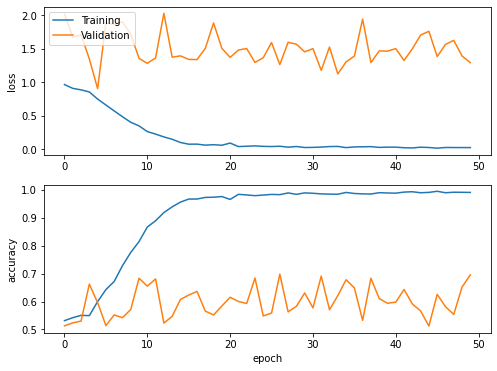

In [46]:
draw_plt(history)

In [47]:
score = model.evaluate([test_left, test_right], test_target, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.7142583131790161 / Test accuracy: 0.5732886791229248


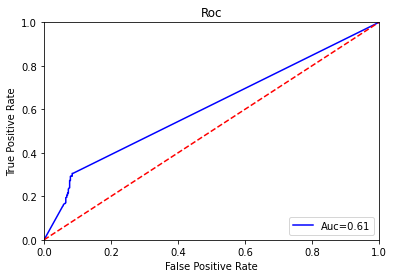

In [48]:
y_pred = model.predict([test_left, test_right])
draw_roc(test_target,y_pred)

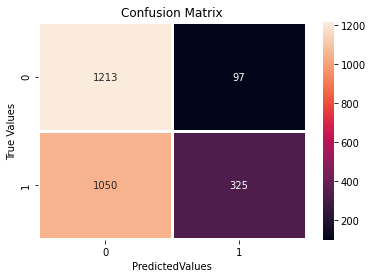

In [49]:
y_pred = fix_it(y_pred)
draw_cm(test_target,y_pred)

In [50]:
f1_score(test_target,y_pred)

0.36171396772398445

In [51]:
fpr, tpr, thresholds =  metrics.roc_curve(test_target, y_pred)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer*100

45.19653345381361

In [52]:
model.save_weights("models/opt_rms.h5")

##SGD optimizer ile eğitim

In [53]:
opt=SGD(lr=constant_learning_rate)

model = siamese_model((224,224, 1))
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32)           318720      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential_2[0][0]         

In [54]:
history = model.fit(
    [train_left, train_right],
    target,
    epochs=50,
    validation_split=0.2,
    batch_size=112,
)

Epoch 1/50
42/42 [==============================] - 32s 746ms/step - loss: 1.4125 - accuracy: 0.5315 - val_loss: 2.0336 - val_accuracy: 0.5130
Epoch 2/50
42/42 [==============================] - 30s 718ms/step - loss: 1.0144 - accuracy: 0.5326 - val_loss: 2.0245 - val_accuracy: 0.5130
Epoch 3/50
42/42 [==============================] - 30s 717ms/step - loss: 0.9421 - accuracy: 0.5285 - val_loss: 2.0092 - val_accuracy: 0.5130
Epoch 4/50
42/42 [==============================] - 30s 722ms/step - loss: 0.8543 - accuracy: 0.5296 - val_loss: 1.9975 - val_accuracy: 0.5130
Epoch 5/50
42/42 [==============================] - 30s 718ms/step - loss: 0.8310 - accuracy: 0.5314 - val_loss: 1.6954 - val_accuracy: 0.5130
Epoch 6/50
42/42 [==============================] - 30s 720ms/step - loss: 0.8065 - accuracy: 0.5261 - val_loss: 1.8635 - val_accuracy: 0.5130
Epoch 7/50
42/42 [==============================] - 30s 721ms/step - loss: 0.8007 - accuracy: 0.5301 - val_loss: 1.6614 - val_accuracy: 0.5471

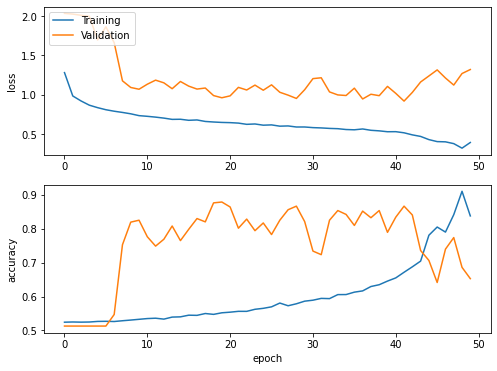

In [55]:
draw_plt(history)

In [56]:
score = model.evaluate([test_left, test_right], test_target, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.349712610244751 / Test accuracy: 0.6063988208770752


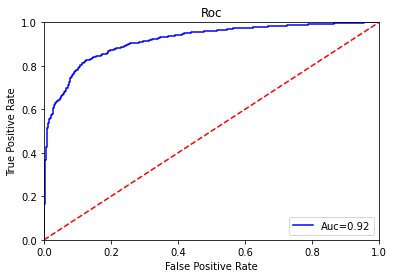

In [57]:
y_pred = model.predict([test_left, test_right])
draw_roc(test_target,y_pred)

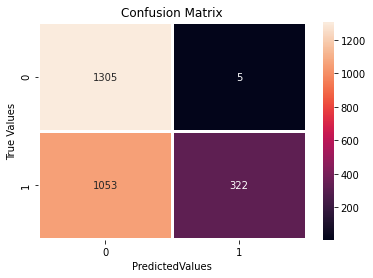

In [58]:
y_pred = fix_it(y_pred)
draw_cm(test_target,y_pred)

In [59]:
f1_score(test_target,y_pred)

0.37837837837837834

In [60]:
fpr, tpr, thresholds =  metrics.roc_curve(test_target, y_pred)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer*100

43.46297267790554

In [61]:
model.save_weights("models/opt_sgd.h5")

#Learning Rate Tespiti

## 0,001 learning rate ile eğitim

In [39]:
initial_learning_rate = 1e-3
lrm = LearningRateScheduler(lr_step_decay, verbose=0)

In [40]:
opt=Adam(lr=initial_learning_rate)

model = siamese_model((224,224, 1))
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 32)           318720      input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           sequential_3[0][0]         

In [41]:
history = model.fit(
    [train_left, train_right],
    target,
    epochs=50,
    validation_split=0.2,
    batch_size=112,
    callbacks=[lrm],
)

Epoch 1/50
42/42 [==============================] - 32s 725ms/step - loss: 1.1858 - accuracy: 0.5321 - val_loss: 2.0347 - val_accuracy: 0.5130
Epoch 2/50
42/42 [==============================] - 31s 730ms/step - loss: 0.8204 - accuracy: 0.5278 - val_loss: 2.0158 - val_accuracy: 0.5130
Epoch 3/50
42/42 [==============================] - 30s 718ms/step - loss: 0.7440 - accuracy: 0.5329 - val_loss: 1.9869 - val_accuracy: 0.5130
Epoch 4/50
42/42 [==============================] - 30s 721ms/step - loss: 0.7128 - accuracy: 0.5414 - val_loss: 1.8939 - val_accuracy: 0.5130
Epoch 5/50
42/42 [==============================] - 30s 721ms/step - loss: 0.6807 - accuracy: 0.5467 - val_loss: 1.6866 - val_accuracy: 0.5138
Epoch 6/50
42/42 [==============================] - 30s 720ms/step - loss: 0.6603 - accuracy: 0.5629 - val_loss: 1.5677 - val_accuracy: 0.5154
Epoch 7/50
42/42 [==============================] - 30s 722ms/step - loss: 0.6255 - accuracy: 0.5866 - val_loss: 1.0579 - val_accuracy: 0.8028

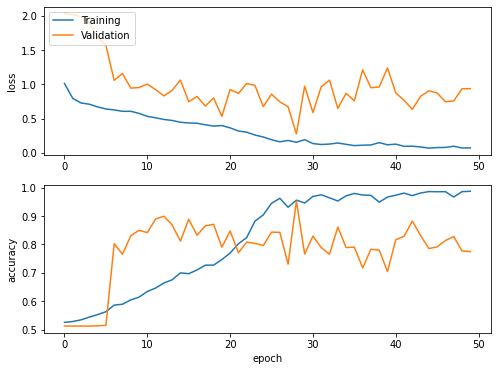

In [42]:
draw_plt(history)

Text(0.5, 0, 'epoch')

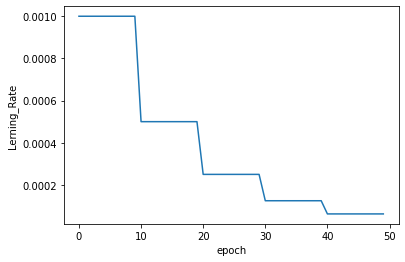

In [43]:
plt.plot(history.history['lr'])
plt.ylabel('Lerning_Rate')
plt.xlabel('epoch')

In [44]:
score = model.evaluate([test_left, test_right], test_target, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.9663714170455933 / Test accuracy: 0.7872023582458496


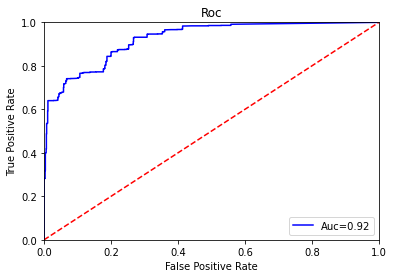

In [45]:
y_pred = model.predict([test_left, test_right])
draw_roc(test_target,y_pred)

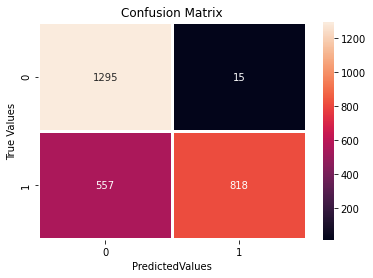

In [46]:
y_pred = fix_it(y_pred)
draw_cm(test_target,y_pred)

In [47]:
f1_score(test_target,y_pred)

0.7409420289855072

In [48]:
fpr, tpr, thresholds =  metrics.roc_curve(test_target, y_pred)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer*100

29.06710167530113

In [49]:
model.save_weights("models/lr_3.h5")

## 0,0001 learning rate ile eğitim

In [50]:
initial_learning_rate = 1e-4
lrm = LearningRateScheduler(lr_step_decay, verbose=0)

In [51]:
opt=Adam(lr=initial_learning_rate)

model = siamese_model((224,224, 1))
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32)           318720      input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 1)            0           sequential_4[0][0]         

In [52]:
history = model.fit(
    [train_left, train_right],
    target,
    epochs=50,
    validation_split=0.2,
    batch_size=112,
    callbacks=[lrm],
)

Epoch 1/50
42/42 [==============================] - 33s 744ms/step - loss: 1.1285 - accuracy: 0.5293 - val_loss: 2.0199 - val_accuracy: 0.5130
Epoch 2/50
42/42 [==============================] - 30s 719ms/step - loss: 0.8354 - accuracy: 0.5313 - val_loss: 2.0230 - val_accuracy: 0.5130
Epoch 3/50
42/42 [==============================] - 30s 720ms/step - loss: 0.7639 - accuracy: 0.5386 - val_loss: 2.0159 - val_accuracy: 0.5130
Epoch 4/50
42/42 [==============================] - 30s 727ms/step - loss: 0.6824 - accuracy: 0.5385 - val_loss: 1.9096 - val_accuracy: 0.5130
Epoch 5/50
42/42 [==============================] - 30s 720ms/step - loss: 0.6694 - accuracy: 0.5520 - val_loss: 1.8901 - val_accuracy: 0.5130
Epoch 6/50
42/42 [==============================] - 30s 719ms/step - loss: 0.6450 - accuracy: 0.5651 - val_loss: 1.6045 - val_accuracy: 0.5357
Epoch 7/50
42/42 [==============================] - 30s 721ms/step - loss: 0.6096 - accuracy: 0.5772 - val_loss: 1.5305 - val_accuracy: 0.5576

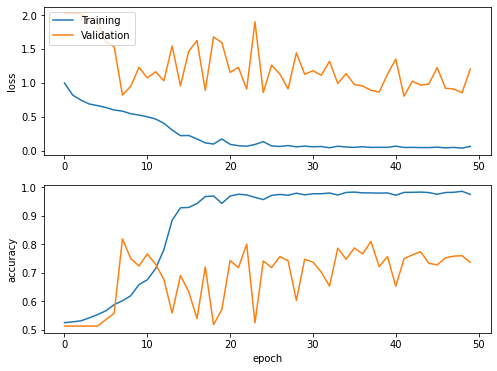

In [53]:
draw_plt(history)

Text(0.5, 0, 'epoch')

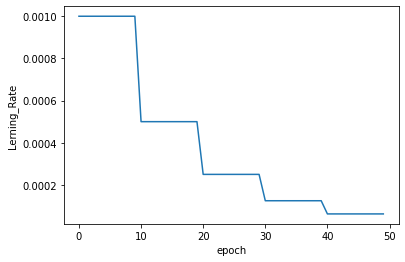

In [54]:
plt.plot(history.history['lr'])
plt.ylabel('Lerning_Rate')
plt.xlabel('epoch')

In [55]:
score = model.evaluate([test_left, test_right], test_target, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.158204436302185 / Test accuracy: 0.7317708134651184


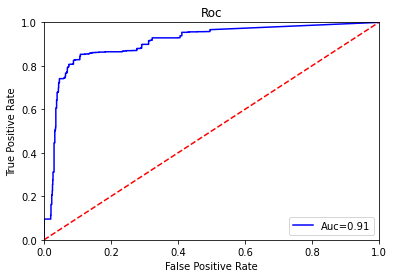

In [56]:
y_pred = model.predict([test_left, test_right])
draw_roc(test_target,y_pred)

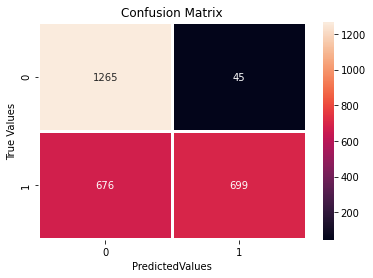

In [57]:
y_pred = fix_it(y_pred)
draw_cm(test_target,y_pred)

In [58]:
f1_score(test_target,y_pred)

0.6597451628126475

In [59]:
fpr, tpr, thresholds =  metrics.roc_curve(test_target, y_pred)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer*100

33.73645442649057

In [60]:
model.save_weights("models/lr_4.h5")

## 0,00001 learning rate ile eğitim

In [20]:
initial_learning_rate = 1e-5
lrm = LearningRateScheduler(lr_step_decay, verbose=0)

In [21]:
opt=Adam(lr=initial_learning_rate )

model = siamese_model((224,224, 1))
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[accuracy])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           318720      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[0][0]         

In [22]:
history = model.fit(
    [train_left, train_right],
    target,
    epochs=50,
    validation_split=0.2,
    batch_size=112,
    callbacks=[lrm],
)

Epoch 1/50
42/42 [==============================] - 34s 769ms/step - loss: 1.2149 - accuracy: 0.5248 - val_loss: 2.0336 - val_accuracy: 0.5130
Epoch 2/50
42/42 [==============================] - 30s 712ms/step - loss: 0.8198 - accuracy: 0.5304 - val_loss: 2.0261 - val_accuracy: 0.5130
Epoch 3/50
42/42 [==============================] - 30s 726ms/step - loss: 0.7493 - accuracy: 0.5290 - val_loss: 1.9930 - val_accuracy: 0.5130
Epoch 4/50
42/42 [==============================] - 30s 716ms/step - loss: 0.6925 - accuracy: 0.5519 - val_loss: 1.9239 - val_accuracy: 0.5130
Epoch 5/50
42/42 [==============================] - 30s 720ms/step - loss: 0.6644 - accuracy: 0.5671 - val_loss: 1.7887 - val_accuracy: 0.5130
Epoch 6/50
42/42 [==============================] - 30s 720ms/step - loss: 0.6378 - accuracy: 0.5780 - val_loss: 1.5387 - val_accuracy: 0.5357
Epoch 7/50
42/42 [==============================] - 30s 721ms/step - loss: 0.6467 - accuracy: 0.5909 - val_loss: 0.9845 - val_accuracy: 0.8377

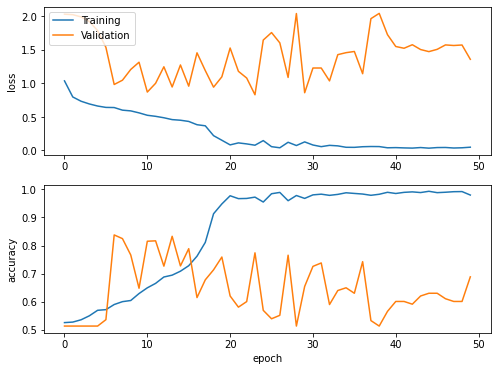

In [23]:
draw_plt(history)

Text(0.5, 0, 'epoch')

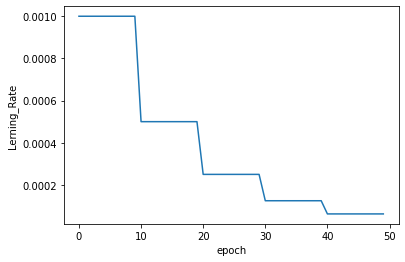

In [24]:
plt.plot(history.history['lr'])
plt.ylabel('Lerning_Rate')
plt.xlabel('epoch')

In [25]:
score = model.evaluate([test_left, test_right], test_target, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.2045351266860962 / Test accuracy: 0.6941964030265808


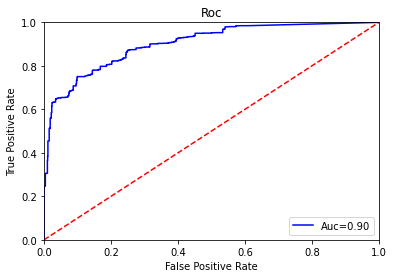

In [26]:
y_pred = model.predict([test_left, test_right])
draw_roc(test_target,y_pred)

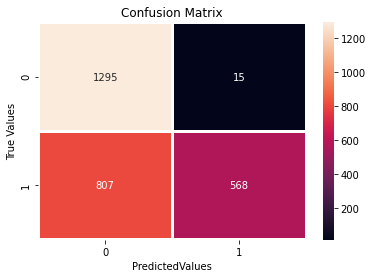

In [27]:
y_pred = fix_it(y_pred)
draw_cm(test_target,y_pred)

In [28]:
f1_score(test_target,y_pred)

0.5801838610827375

In [29]:
fpr, tpr, thresholds =  metrics.roc_curve(test_target, y_pred)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer*100

37.25321948909714

In [30]:
model.save_weights("models/lr_5.h5")

#Epoch tespiti

In [20]:
initial_learning_rate = 0.001
best_opt=Adam(lr=initial_learning_rate)
lrm = LearningRateScheduler(lr_step_decay, verbose=0)

##100 Epoch ile eğitim

In [30]:
model =siamese_model((224,224, 1))
model.compile(loss=contrastive_loss, optimizer=best_opt, metrics=[accuracy])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           318720      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[0][0]         

In [33]:
history = model.fit(
    [train_left, train_right],
    target,
    epochs=100,
    validation_split=0.2,
    batch_size=112,
    callbacks=[lrm],
)

Epoch 1/100
42/42 [==============================] - 33s 754ms/step - loss: 1.1637 - accuracy: 0.5290 - val_loss: 2.0264 - val_accuracy: 0.5130
Epoch 2/100
42/42 [==============================] - 30s 727ms/step - loss: 0.8046 - accuracy: 0.5264 - val_loss: 1.9945 - val_accuracy: 0.5130
Epoch 3/100
42/42 [==============================] - 30s 715ms/step - loss: 0.7281 - accuracy: 0.5398 - val_loss: 1.9651 - val_accuracy: 0.5130
Epoch 4/100
42/42 [==============================] - 30s 721ms/step - loss: 0.6867 - accuracy: 0.5453 - val_loss: 1.8565 - val_accuracy: 0.5130
Epoch 5/100
42/42 [==============================] - 30s 722ms/step - loss: 0.6412 - accuracy: 0.5779 - val_loss: 1.8420 - val_accuracy: 0.5130
Epoch 6/100
42/42 [==============================] - 30s 720ms/step - loss: 0.6409 - accuracy: 0.5757 - val_loss: 1.6000 - val_accuracy: 0.5130
Epoch 7/100
42/42 [==============================] - 30s 720ms/step - loss: 0.5908 - accuracy: 0.6132 - val_loss: 1.3334 - val_accuracy:

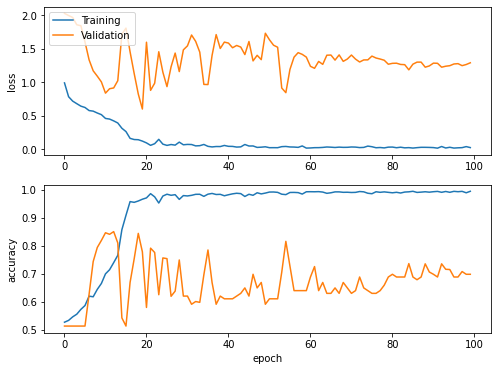

In [34]:
draw_plt(history)

Text(0.5, 0, 'epoch')

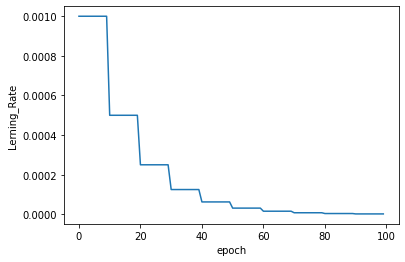

In [35]:
plt.plot(history.history['lr'])
plt.ylabel('Lerning_Rate')
plt.xlabel('epoch')

In [32]:
score = model.evaluate([test_left, test_right], test_target, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5793230533599854 / Test accuracy: 0.8575148582458496


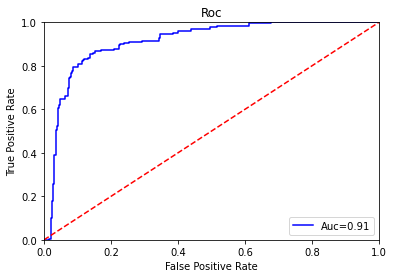

In [33]:
y_pred = model.predict([test_left, test_right])
draw_roc(test_target,y_pred)

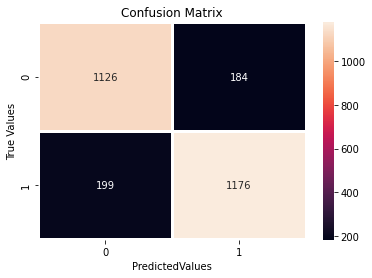

In [34]:
y_pred = fix_it(y_pred)
draw_cm(test_target,y_pred)

In [35]:
f1_score(test_target,y_pred)

0.859963436928702

In [36]:
fpr, tpr, thresholds =  metrics.roc_curve(test_target, y_pred)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer*100

14.411202140480059

In [37]:
model.save_weights("models/epoch1.h5")

##200 Epoch ile eğitim

In [38]:
model = siamese_model((224,224, 1))
model.compile(loss=contrastive_loss, optimizer=best_opt, metrics=[accuracy])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32)           318720      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential_2[0][0]         

In [39]:
history = model.fit(
    [train_left, train_right],
    target,
    epochs=200,
    validation_split=0.2,
    batch_size=112,
    callbacks=[lrm],
)

Epoch 1/200
42/42 [==============================] - 36s 788ms/step - loss: 1.1776 - accuracy: 0.5204 - val_loss: 2.0329 - val_accuracy: 0.5130
Epoch 2/200
42/42 [==============================] - 31s 730ms/step - loss: 0.7914 - accuracy: 0.5130 - val_loss: 1.9962 - val_accuracy: 0.5130
Epoch 3/200
42/42 [==============================] - 30s 718ms/step - loss: 0.7259 - accuracy: 0.5278 - val_loss: 1.9838 - val_accuracy: 0.5130
Epoch 4/200
42/42 [==============================] - 30s 722ms/step - loss: 0.6687 - accuracy: 0.5508 - val_loss: 1.9098 - val_accuracy: 0.5130
Epoch 5/200
42/42 [==============================] - 30s 722ms/step - loss: 0.6597 - accuracy: 0.5641 - val_loss: 1.8242 - val_accuracy: 0.5130
Epoch 6/200
42/42 [==============================] - 30s 721ms/step - loss: 0.6406 - accuracy: 0.5684 - val_loss: 1.3729 - val_accuracy: 0.6193
Epoch 7/200
42/42 [==============================] - 30s 723ms/step - loss: 0.6023 - accuracy: 0.5773 - val_loss: 1.3878 - val_accuracy:

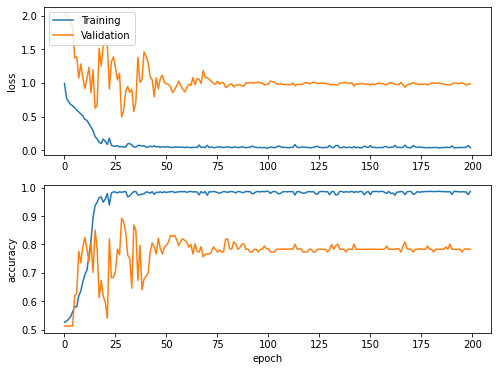

In [40]:
draw_plt(history)

Text(0.5, 0, 'epoch')

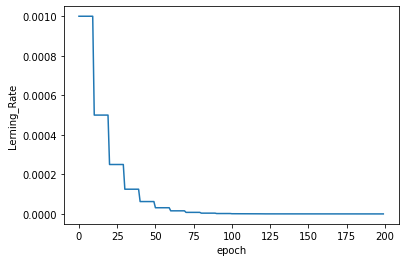

In [41]:
plt.plot(history.history['lr'])
plt.ylabel('Lerning_Rate')
plt.xlabel('epoch')

In [42]:
score = model.evaluate([test_left, test_right], test_target, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.9531881809234619 / Test accuracy: 0.7578125


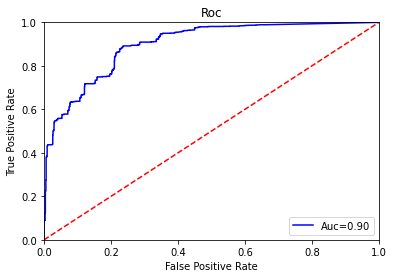

In [43]:
y_pred = model.predict([test_left, test_right])
draw_roc(test_target,y_pred)

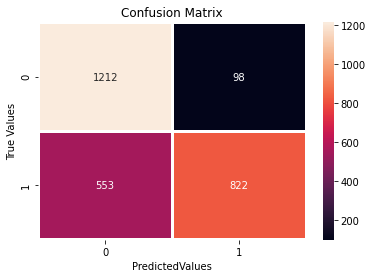

In [44]:
y_pred = fix_it(y_pred)
draw_cm(test_target,y_pred)

In [45]:
f1_score(test_target,y_pred)

0.7163398692810456

In [49]:
fpr, tpr, thresholds =  metrics.roc_curve(test_target, y_pred)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer*100

30.299088639148785

In [47]:
model.save_weights("models/epoch2.h5")